In [1]:
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
import numpy as np

## Loading the dataset
We make sure to parse categorical variables and dates correctly like described in the [eda](../eda/tracks-eda.ipynb). 

In [2]:
# open json
df = pd.read_json('../data/feature_extr_tracks.json')
df['album_release_date'] = df['album_release_date'].astype('datetime64[ms]')
# change columns_of_interest to categorical
columns_of_interest = ['sub_genre', 'main_genre', 'time_signature', 'mode', 'key', 'track_number', 'disc_number']
df[columns_of_interest] = df[columns_of_interest].astype('str')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 356 entries, 0 to 355
Data columns (total 35 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   added_at                356 non-null    datetime64[ns]
 1   id                      356 non-null    object        
 2   uri                     356 non-null    object        
 3   name                    356 non-null    object        
 4   popularity              356 non-null    int64         
 5   track_number            356 non-null    object        
 6   disc_number             356 non-null    object        
 7   explicit                356 non-null    bool          
 8   duration_ms             356 non-null    int64         
 9   album_id                356 non-null    object        
 10  album_name              356 non-null    object        
 11  album_uri               356 non-null    object        
 12  artists                 356 non-null    object    

In [4]:
df['album_release_date']

0     2022-08-05
1     2022-06-10
2     2019-03-22
3     2022-08-26
4     2017-03-01
         ...    
351   2007-01-01
352   2016-04-19
353   2012-01-01
354   2018-08-03
355   2018-04-27
Name: album_release_date, Length: 356, dtype: datetime64[ms]

A plot to assess the feasability of classifiying genres with linear classification. Almost all of the feature distributions overlap significantly and even the bi plots don't show any clear seperation between classes. 

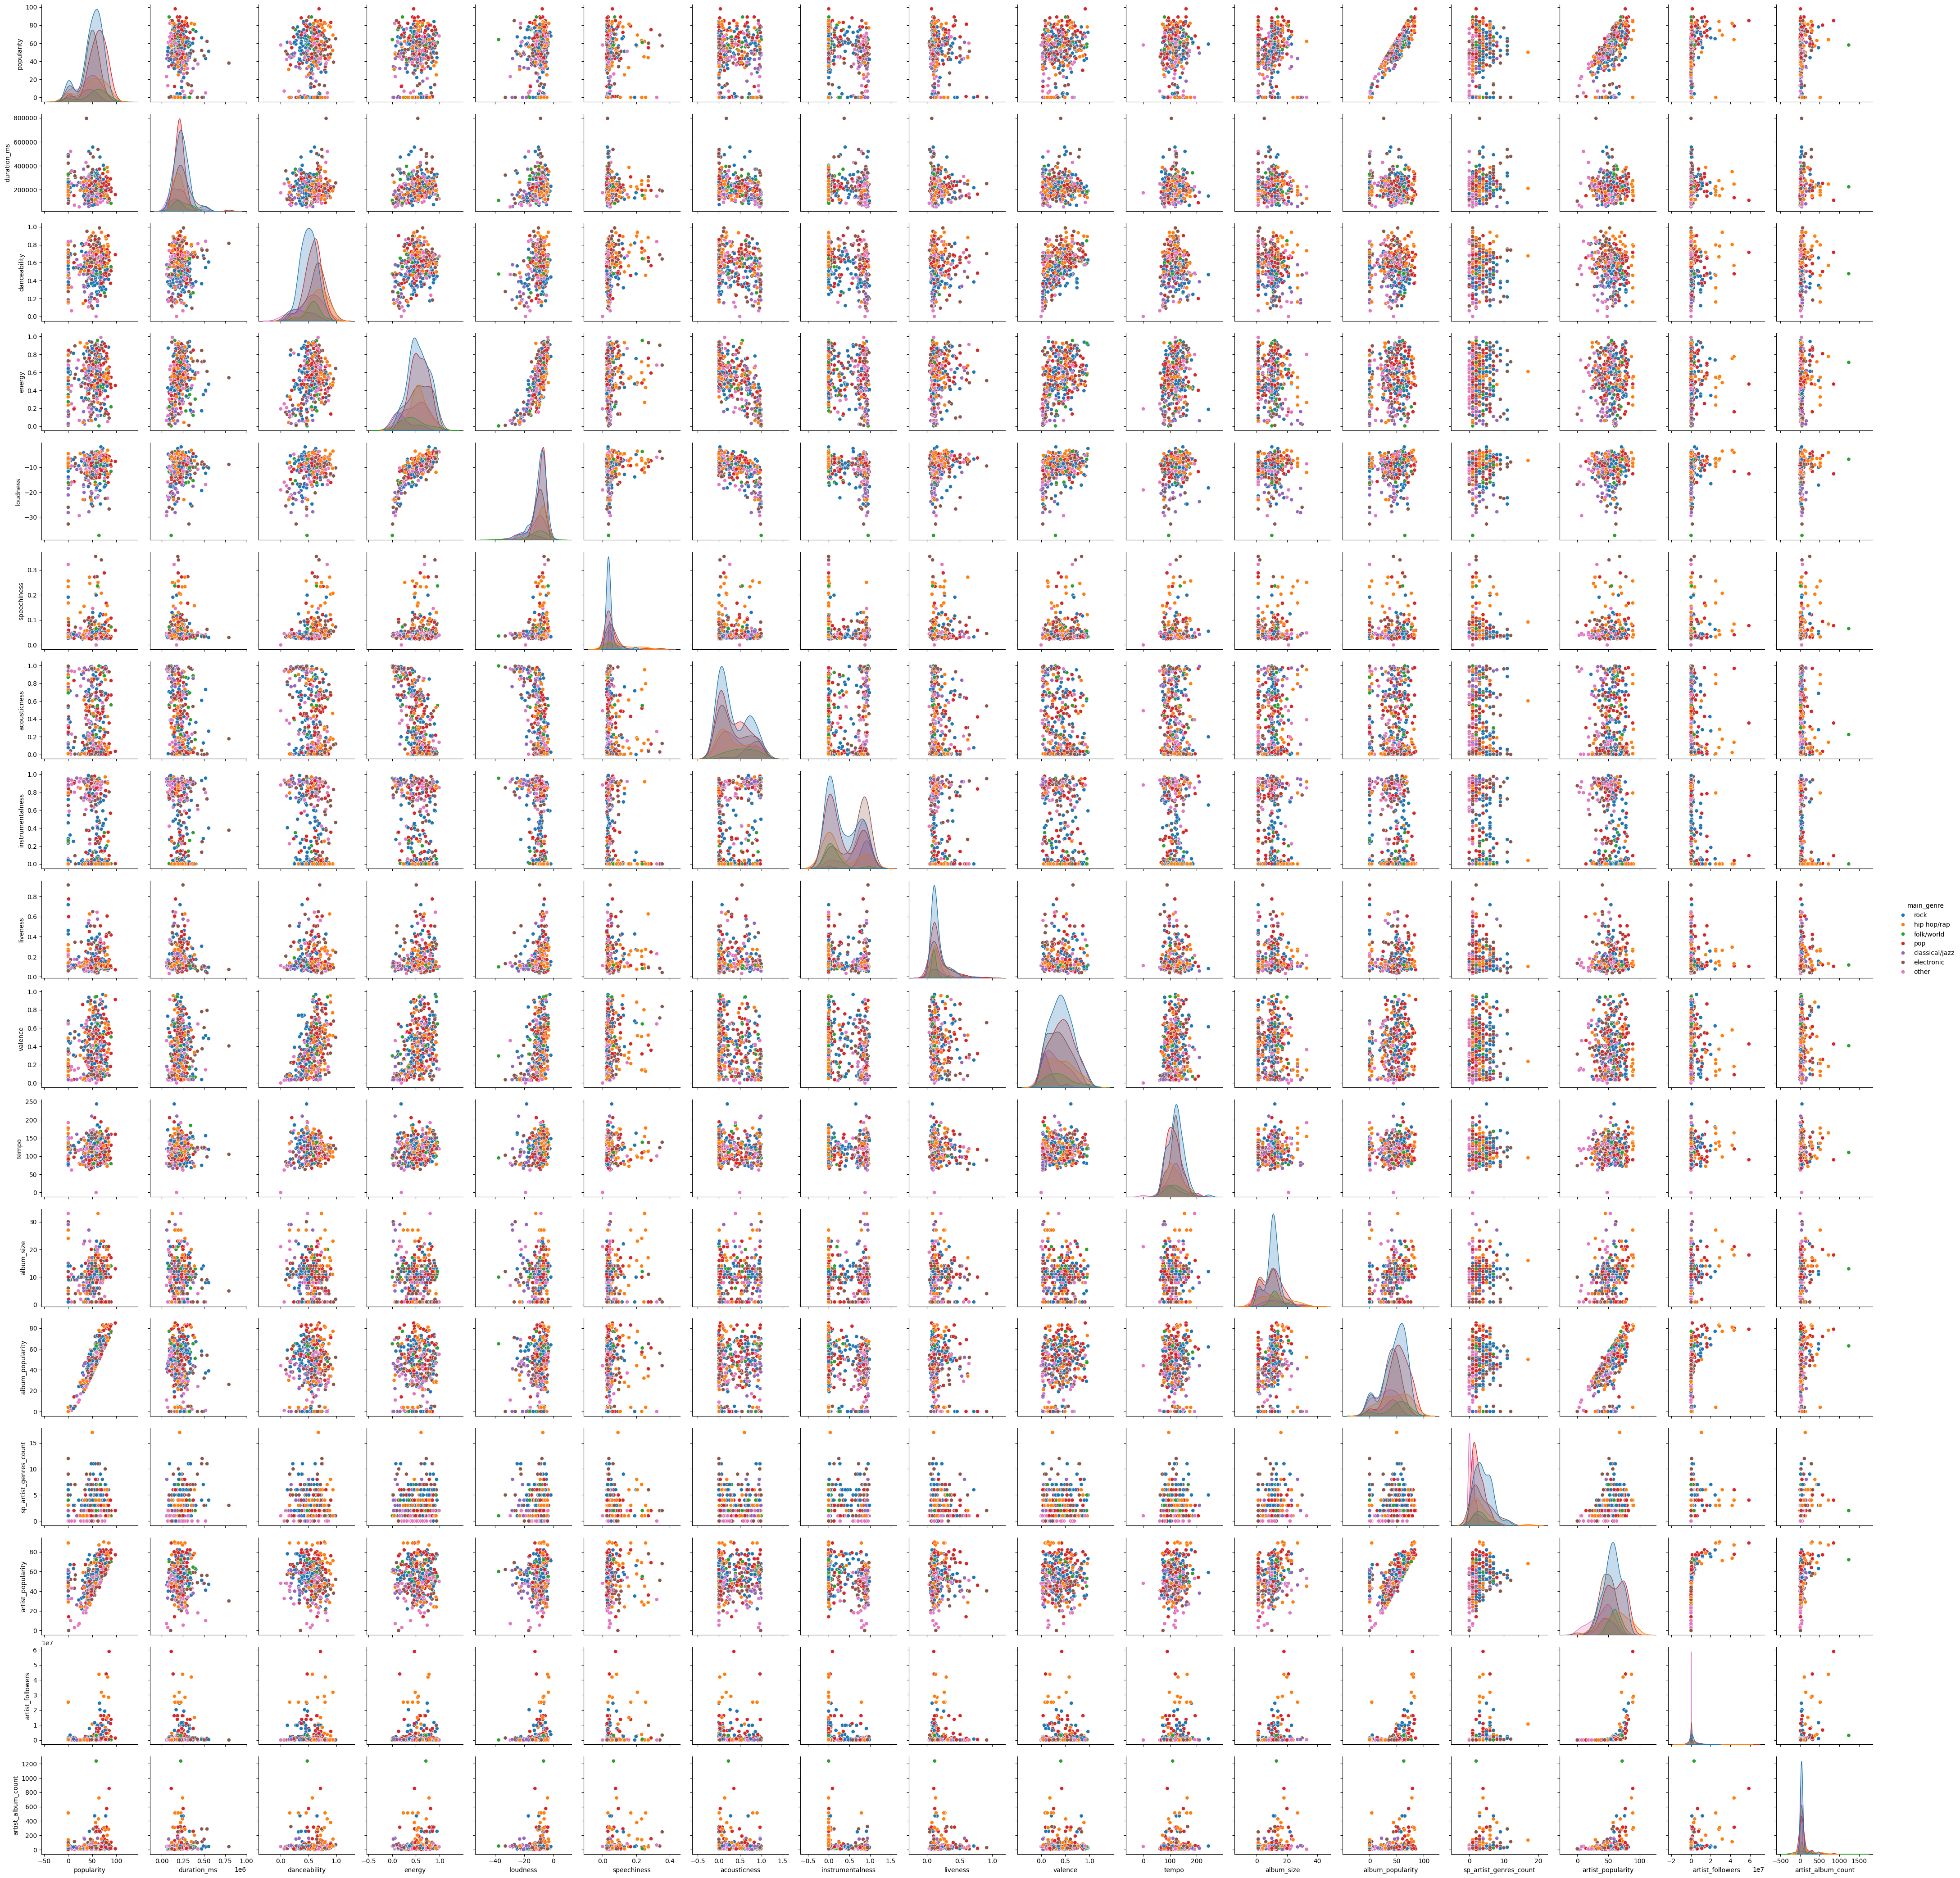

In [5]:
numeric_columns = list(df.select_dtypes(include=[np.number]).columns)
numeric_columns.append('main_genre')
sns.pairplot(data = df.loc[:, numeric_columns], hue='main_genre')

We are excluding values that are obviously uninformative or are too granular to be used for QDA since we'd have more variables than songs in the dataset. We also exclude sub_genre because it is not realistic we'd know the subgenre of a song at inference time. 
id, uri, name, track_number, disc_number, album_id, album_name, album_uri, sub_genre

## Feature engineering

### Selecting features
We drop `album_popularity` since we saw in [feature_engineering](../eda/feature-engineering.ipynb) that this value is correlated with `popularity` which can cause issues with modeling. 

In [6]:
X = df.loc[:, [
'added_at',
'popularity',
'explicit',
'duration_ms',
'artists',
'danceability',
'energy',
'key',
'loudness',
'mode',
'speechiness',
'acousticness',
'instrumentalness',
'liveness',
'valence',
'tempo',
'time_signature',
'album_size',
# 'album_popularity',
'album_release_date',
'album_type',
'sp_artist_genres_count',
'artist_popularity',
'artist_followers',
'artist_album_count']]
y = df.loc[:, 'main_genre']

### Calculating features

The artists feature is an array of id's of artists that partisipated in the song. To encode this information we calculate the number of artists that partisipated. 

In [7]:
X["artist_count"] = X["artists"].apply(lambda x: len(x))
X = X.drop("artists", axis=1)

For the date features `added_at` and `album_release_date` we calculate the number of days since the `max(added_at)` (notice that `added_at` nessecarily greater than `album_release_date` for any given song so the parsed value will always be greater then zero). 

In [8]:
added_at = X["added_at"].max() - X["added_at"]
album_release = X["added_at"].max() - X["album_release_date"]
added_at = added_at.apply(lambda x: x.days)
album_release = album_release.apply(lambda x: x.days)
X = X.astype({'added_at': 'int64'})
X = X.astype({'album_release_date': 'int64'})
X.loc[:, "added_at"] = added_at
X.loc[:, "album_release_date"] = album_release

In [9]:
X.head()

added_at  popularity  explicit  duration_ms  danceability  energy key  \
0         0          67     False       156000         0.563   0.121   0   
1         0          58     False       144204         0.750   0.468   4   
2         3          33     False       137624         0.564   0.534   7   
3         3          74     False       174706         0.547   0.399  10   
4         4          60     False       340999         0.244   0.415   4   

   loudness mode  speechiness  ...    tempo  time_signature  album_size  \
0   -24.797    1       0.0361  ...  160.134               4           9   
1   -16.981    0       0.0288  ...  109.989               4          10   
2    -9.234    1       0.1550  ...   86.547               4           7   
3    -9.808    1       0.0246  ...   84.127               4          12   
4    -6.589    0       0.0300  ...  184.318               3           6   

   album_release_date  album_type sp_artist_genres_count  artist_popularity  \
0                 641       album                      1               64.0   
1                 697       album                      3               52.0   
2                1873       album                      1               45.0   
3                 620       album                      2               64.0   
4                2624       album                      1               58.0   

   artist_followers artist_album_count  artist_count  
0          386578.0               10.0             1  
1           85543.0                1.0             1  
2           82649.0               44.0             1  
3          482230.0               14.0             1  
4         1666987.0               36.0             1  

[5 rows x 24 columns]

### Reformatting features
We apply one-hot-encoding to our categorical predictors and use Min-Max scaling to scale our numeric predictors

In [10]:
def preprocessing(X, y, scaler=None): 
    # for some reason non-explicit dtype convertion will be deprecated so this is needed
    # to explicitly type the int64 columns as float64
    dtypes_convert = {col: 'float64' for col in X.select_dtypes(include=['int64']).columns}
    X = X.astype(dtypes_convert)

    numerical_cols = list(X.select_dtypes(include=[np.number]).columns)   
    # We scale the numerical columns
    if scaler is None: 
        # We only want the scaler to fit the train data
        scaler = MinMaxScaler()
        X.loc[:,numerical_cols] = scaler.fit_transform(X[numerical_cols])
    else: 
        X.loc[:,numerical_cols] = scaler.transform(X[numerical_cols]) 
    return X, y, scaler

In [11]:
# apply one-hot-encoding to the categorical columns and normalize numerical ones
X = pd.get_dummies(X,drop_first=True)

X, _, _ = preprocessing(X, y)

Looking at the correlation matrix we can see that there are a few variables that are highly negatively correlated. 

Namely the dummy variable `album_type_single` is negativley correlated with `album_size` and `acousticness` is negatively correlated with `energy` and `loudness`. `energy` and `loudness` are the ones with the hightest positive correlation.

All of these correlations are very intuative but before we remove them we will assess the variation inflation factor to see if hey pose issues. 

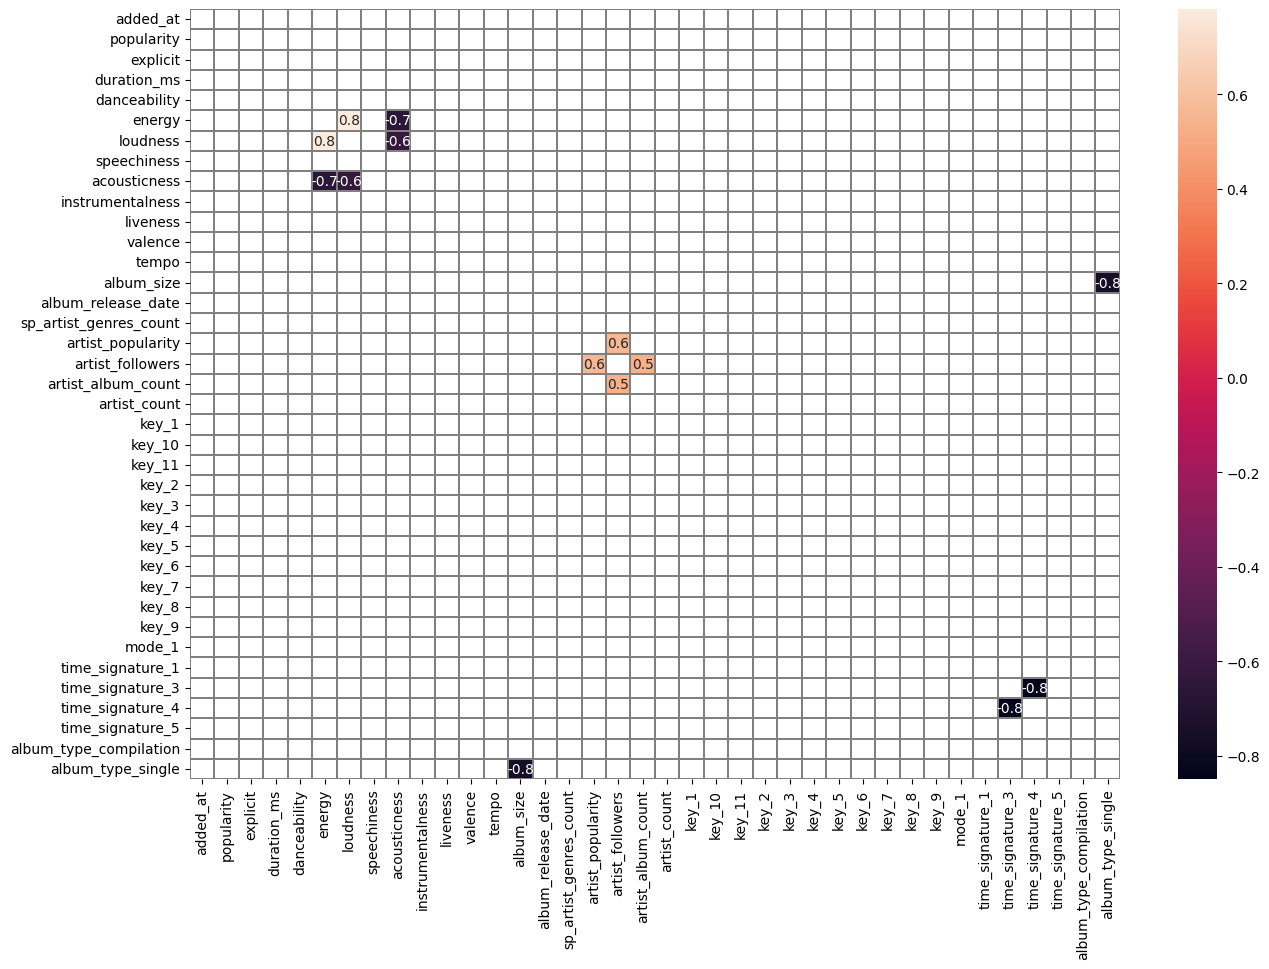

In [12]:
correlation_matrix = X.corr()
_mask = correlation_matrix.map(lambda x: abs(x) < 0.5 or abs(x) == 1)
plt.figure(figsize=(15,10))
sns.heatmap(correlation_matrix, annot=True, mask=_mask, linewidths=0.1, linecolor='gray', fmt='.1f') 
plt.show()

In [13]:
X_filtered = X.copy()
X_filtered = X_filtered.astype({col: 'int64' for col in X_filtered.select_dtypes(include=bool).columns})
while True: 
    X_numeric = X_filtered.select_dtypes(include=[np.number])
    vif_df = pd.DataFrame()
    vif_df['variable'] = X_numeric.columns 

    #calculate VIF for each predictor variable 
    vif_df['VIF'] = [variance_inflation_factor(X_numeric, i) for i in range(X_numeric.shape[1])]

    #view VIF for each predictor variable 
    vif_df = vif_df.sort_values(by='VIF', ascending=False)
    if vif_df.iloc[0]['VIF'] > 3.0: 
        print(vif_df.head(1))
        X_filtered.drop(vif_df.iloc[0]['variable'], axis=1, inplace=True)
    else: 
        break

            variable         VIF
34  time_signature_4  118.420733
   variable        VIF
6  loudness  72.007394
             variable        VIF
15  artist_popularity  25.921994
       variable        VIF
4  danceability  17.546365
   variable        VIF
10    tempo  16.230206
  variable        VIF
4   energy  12.078921
     variable       VIF
9  album_size  7.157256
     variable       VIF
1  popularity  6.016894
      variable       VIF
2  duration_ms  4.900255
  variable       VIF
6  valence  3.703844
                 variable       VIF
7  sp_artist_genres_count  3.667539
   variable       VIF
0  added_at  3.372145


The variable time_signature_4 is extremely correlated with other features. Since most songs have this time signature (308/356) we drop this entire categorical feature from our data. 

In [14]:
X.drop([time_signature_col for time_signature_col in X.columns if time_signature_col.startswith('time_signature')], axis = 1, inplace=True)

Just to confirm that no other categorical variables need to be dropped we perform tht variable inflation calculation again. 

In [15]:
X_filtered = X.copy()
X_filtered = X_filtered.astype({col: 'int64' for col in X_filtered.select_dtypes(include=bool).columns})
while True: 
    X_numeric = X_filtered.select_dtypes(include=[np.number])
    vif_df = pd.DataFrame()
    vif_df['variable'] = X_numeric.columns 

    #calculate VIF for each predictor variable 
    vif_df['VIF'] = [variance_inflation_factor(X_numeric, i) for i in range(X_numeric.shape[1])]

    #view VIF for each predictor variable 
    vif_df = vif_df.sort_values(by='VIF', ascending=False)
    if vif_df.iloc[0]['VIF'] > 3.0: 
        print(vif_df.head(1))
        X_filtered.drop(vif_df.iloc[0]['variable'], axis=1, inplace=True)
    else: 
        break

   variable        VIF
6  loudness  71.380084
             variable        VIF
15  artist_popularity  25.545968
       variable        VIF
4  danceability  16.704763
   variable        VIF
10    tempo  15.822743
  variable        VIF
4   energy  11.705767
     variable       VIF
9  album_size  7.123556
     variable       VIF
1  popularity  6.011493
      variable      VIF
2  duration_ms  4.85426
                 variable       VIF
8  sp_artist_genres_count  3.668138
  variable       VIF
6  valence  3.558165
   variable       VIF
0  added_at  3.351235


In [16]:
X_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 356 entries, 0 to 355
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   explicit                356 non-null    int64  
 1   speechiness             356 non-null    float64
 2   acousticness            356 non-null    float64
 3   instrumentalness        356 non-null    float64
 4   liveness                356 non-null    float64
 5   album_release_date      356 non-null    float64
 6   artist_followers        356 non-null    float64
 7   artist_album_count      356 non-null    float64
 8   artist_count            356 non-null    float64
 9   key_1                   356 non-null    int64  
 10  key_10                  356 non-null    int64  
 11  key_11                  356 non-null    int64  
 12  key_2                   356 non-null    int64  
 13  key_3                   356 non-null    int64  
 14  key_4                   356 non-null    in

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y, test_size=0.33, random_state=42, stratify=y)
X_train, y_train, scaler = preprocessing(X_train,y_train)
X_test, y_test, _ = preprocessing(X_test,y_test,scaler)

In [18]:
qda_model = QuadraticDiscriminantAnalysis(reg_param=0.1).fit(X_train, y_train)

print('Priors:', qda_model.priors_)
print('Means:\n')
means = pd.DataFrame(qda_model.means_)
means.columns = X_train.columns
means

Priors: [0.04621849 0.18487395 0.04621849 0.1092437  0.10504202 0.22268908
 0.28571429]
Means:



c:\Users\johan\anaconda3\envs\ml_env\Lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


explicit  speechiness  acousticness  instrumentalness  liveness  \
0  0.000000     0.054122      0.787416          0.821886  0.124653   
1  0.090909     0.109537      0.322613          0.644576  0.187019   
2  0.000000     0.037393      0.480392          0.093986  0.108534   
3  0.500000     0.197185      0.344756          0.262548  0.165077   
4  0.120000     0.088680      0.466679          0.693163  0.105688   
5  0.075472     0.104779      0.292298          0.308921  0.169766   
6  0.014706     0.056166      0.298372          0.330903  0.143984   

   album_release_date  artist_followers  artist_album_count  artist_count  \
0            0.181751          0.004890            0.056298      0.181818   
1            0.148950          0.006854            0.053244      0.102273   
2            0.167245          0.014004            0.113710      0.045455   
3            0.169250          0.128698            0.123416      0.153846   
4            0.075967          0.002044            0.016478      0.080000   
5            0.128149          0.066950            0.067051      0.037736   
6            0.266328          0.032770            0.039972      0.014706   

      key_1  ...     key_3     key_4     key_5     key_6     key_7     key_8  \
0  0.000000  ...  0.000000  0.090909  0.090909  0.090909  0.090909  0.090909   
1  0.159091  ...  0.000000  0.068182  0.045455  0.159091  0.136364  0.136364   
2  0.090909  ...  0.090909  0.181818  0.000000  0.090909  0.090909  0.000000   
3  0.153846  ...  0.000000  0.153846  0.038462  0.038462  0.192308  0.153846   
4  0.080000  ...  0.000000  0.040000  0.080000  0.080000  0.080000  0.080000   
5  0.018868  ...  0.037736  0.075472  0.150943  0.056604  0.056604  0.037736   
6  0.117647  ...  0.029412  0.058824  0.117647  0.073529  0.073529  0.014706   

      key_9    mode_1  album_type_compilation  album_type_single  
0  0.000000  0.090909                0.000000           0.181818  
1  0.068182  0.636364                0.000000           0.454545  
2  0.272727  0.545455                0.000000           0.000000  
3  0.076923  0.615385                0.000000           0.346154  
4  0.200000  0.480000                0.040000           0.480000  
5  0.113208  0.490566                0.018868           0.377358  
6  0.073529  0.485294                0.029412           0.161765  

[7 rows x 23 columns]

The algorithm issues a UserWarning that the variables are collinear, but we have not been able to detect any more colinearity between columns, so we continue.

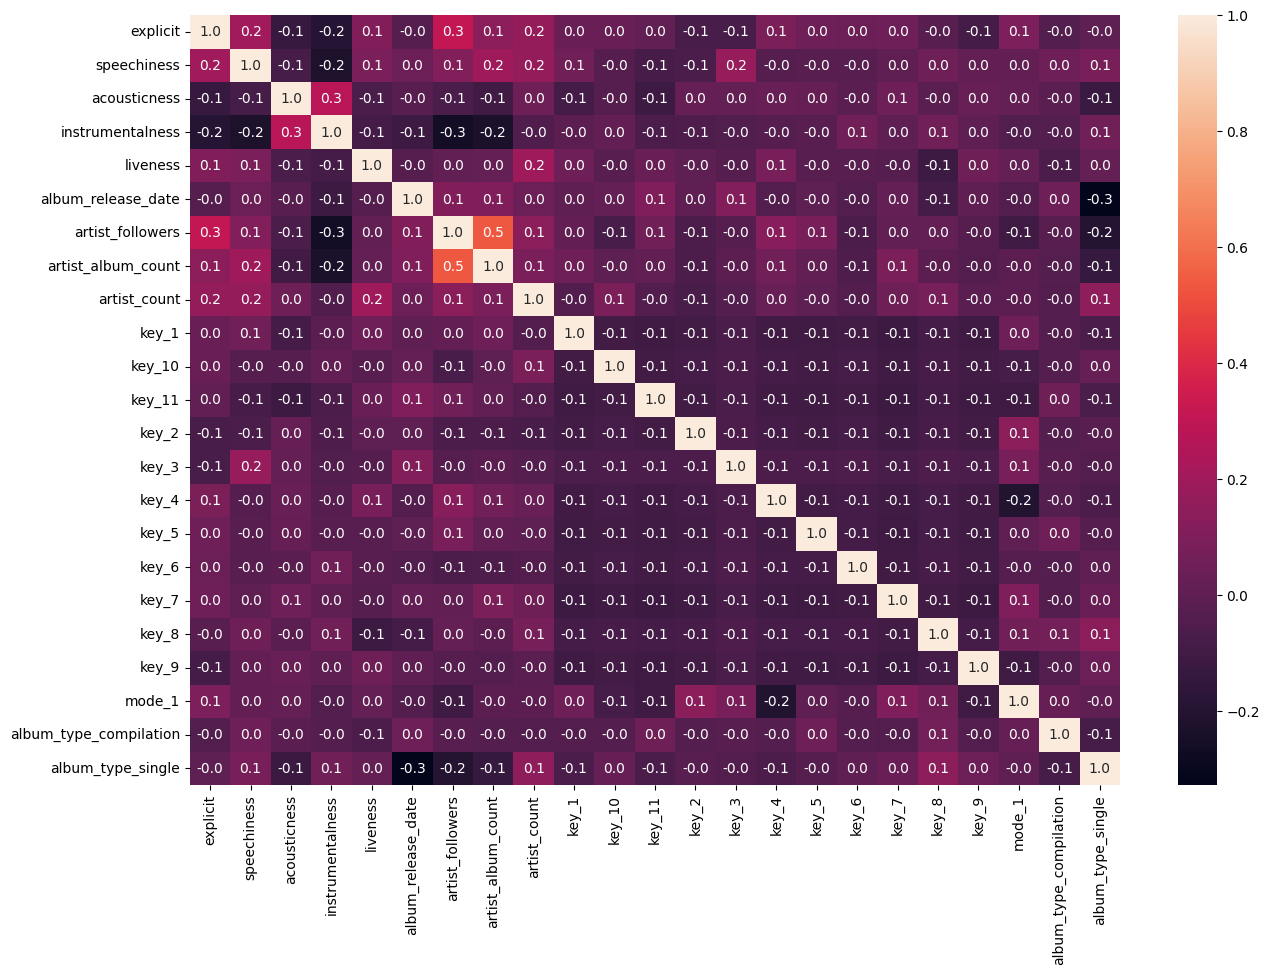

In [19]:
correlation_matrix = X_filtered.corr()
plt.figure(figsize=(15,10))
sns.heatmap(correlation_matrix, annot=True, fmt='.1f') 
plt.show()

### Evaluation

We evaluate the algorithm by visually examining the confusion matricies to identify where the model struggles, and by calculating precision, recall and the F1 score. 

In [20]:
def confusion(true, pred):
    """
    Function for pretty printing confusion matrices.
    """
    true.name = 'target'
    pred.name = 'predicted'
    cm = pd.crosstab(true.reset_index(drop=True), pred.reset_index(drop=True))
    cm_formatted = pd.DataFrame(np.zeros((len(cm), len(cm)), np.int64), columns=cm.index, index=cm.index)
    cm_formatted.loc[:,cm.columns] = cm
    return cm_formatted

The performance on the training data is decent for the majority classes, although it is misclassifying most genres as rock at some point, which is a highly dominant class. 

Some of the under-represented classes have really poor performance, and in the case of classical/jazz and folk/world, the model never predicts them. 

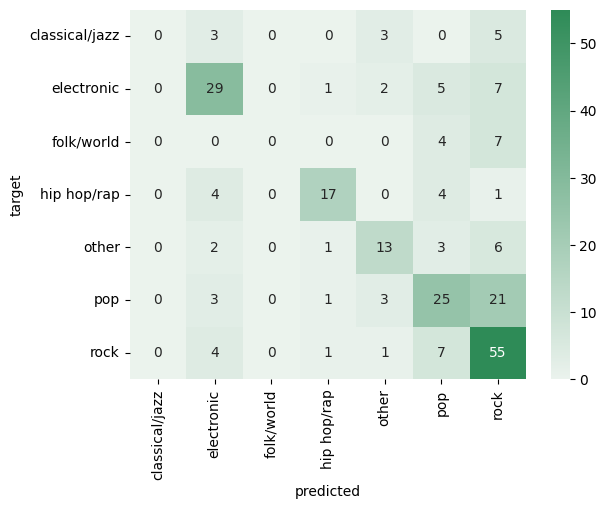

                precision    recall  f1-score   support

classical/jazz       0.00      0.00      0.00        11
    electronic       0.64      0.66      0.65        44
    folk/world       0.00      0.00      0.00        11
   hip hop/rap       0.81      0.65      0.72        26
         other       0.59      0.52      0.55        25
           pop       0.52      0.47      0.50        53
          rock       0.54      0.81      0.65        68

      accuracy                           0.58       238
     macro avg       0.44      0.44      0.44       238
  weighted avg       0.54      0.58      0.55       238



In [21]:
y_pred = pd.Series(qda_model.predict(X_train))
cfm = confusion(y_train, y_pred)   
ax = sns.heatmap(cfm, annot=True, cmap=sns.light_palette('seagreen', as_cmap=True))
ax.set(xlabel='predicted')
plt.show()
print(classification_report(y_train, y_pred, zero_division=0.0))

When we look at the test data, we see that performance actually drops for every class. 

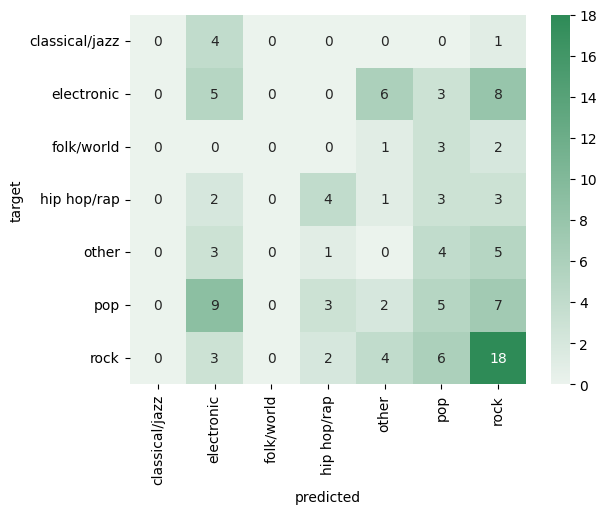

                precision    recall  f1-score   support

classical/jazz       0.00      0.00      0.00         5
    electronic       0.19      0.23      0.21        22
    folk/world       0.00      0.00      0.00         6
   hip hop/rap       0.40      0.31      0.35        13
         other       0.00      0.00      0.00        13
           pop       0.21      0.19      0.20        26
          rock       0.41      0.55      0.47        33

      accuracy                           0.27       118
     macro avg       0.17      0.18      0.17       118
  weighted avg       0.24      0.27      0.25       118



In [22]:
y_pred = pd.Series(qda_model.predict(X_test))
cfm = confusion(y_test, y_pred)
ax = sns.heatmap(cfm, annot=True, cmap=sns.light_palette('seagreen', as_cmap=True))
ax.set(xlabel='predicted')
plt.show()
print(classification_report(y_test, y_pred, zero_division = 0.0))